In [1]:
import re
import os
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
import nltk
#nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Gather Data

In [ ]:
categories = pd.read_csv('data/disaster_categories.csv')
message = pd.read_cs

In [2]:
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql_table('DisasterResponse', engine)

# Assess

How many messages are there?

In [3]:
df['message'].count()

26216

What is this genre?

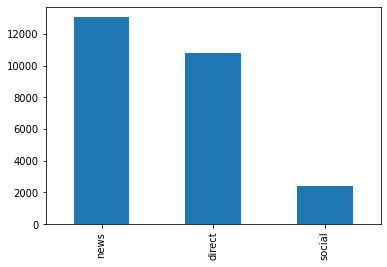

In [4]:
df['genre'].value_counts().plot.bar();

How many have original text?

In [5]:
df['original'].isnull().mean()

0.6120689655172413

What is a word cloud like?

In [26]:
all_text = ' '.join(df['message'].sample(200).to_list())

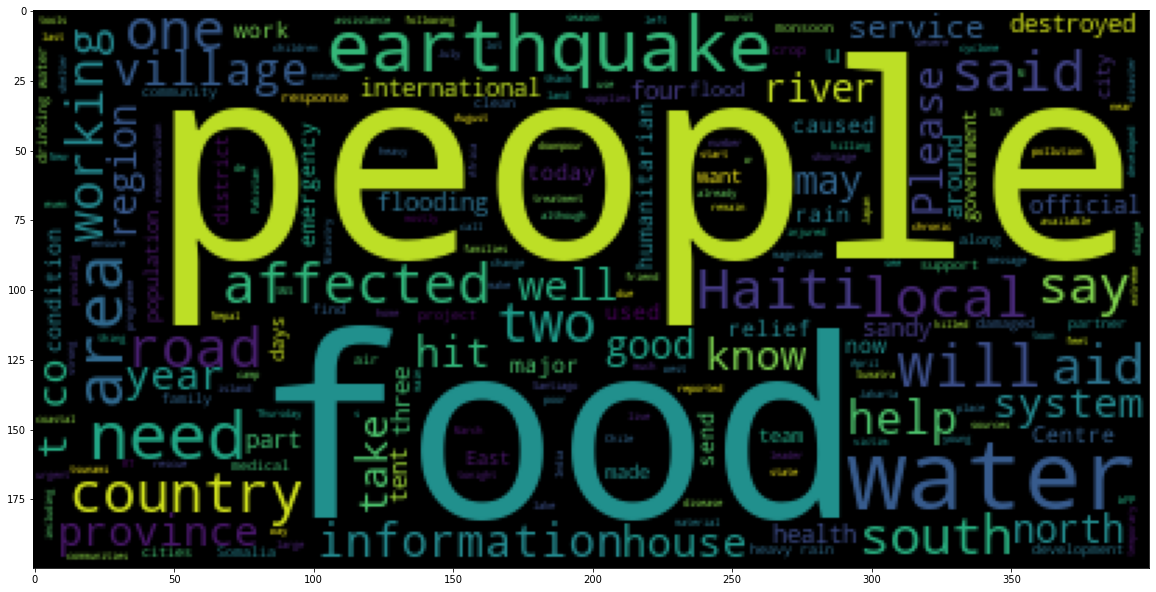

In [27]:
plt.figure(figsize=(20, 20))
plt.imshow(WordCloud().generate(all_text))

# Analyzing categories distribution 

In [28]:
category_columns = set(df.columns) - set(['id', 'message', 'original', 'genre'])

In [29]:
df[category_columns].describe()

,military,cold,food,weather_related,missing_people,other_aid,shelter,hospitals,security,search_and_rescue,...,other_weather,death,clothing,request,shops,transport,direct_report,medical_help,storm,earthquake
count,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,...,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,0.032804,0.020217,0.111497,0.278341,0.011367,0.131446,0.088267,0.010795,0.017966,0.027617,...,0.052487,0.045545,0.015449,0.170659,0.004577,0.045812,0.193584,0.079493,0.093187,0.093645
std,0.178128,0.140743,0.314752,0.448191,0.106011,0.337894,0.283688,0.103338,0.132831,0.163875,...,0.223011,0.208500,0.123331,0.376218,0.067502,0.209081,0.395114,0.270513,0.290700,0.291340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
df['related'].value_counts()

1    19906
0     6122
2      188
Name: related, dtype: int64

In [31]:
df[category_columns].sum()

military                    860
cold                        530
food                       2923
weather_related            7297
missing_people              298
other_aid                  3446
shelter                    2314
hospitals                   283
security                    471
search_and_rescue           724
child_alone                   0
offer                       118
floods                     2155
related                   20282
electricity                 532
other_infrastructure       1151
infrastructure_related     1705
tools                       159
refugees                    875
water                      1672
buildings                  1333
fire                        282
aid_related               10860
aid_centers                 309
money                       604
medical_products           1313
other_weather              1376
death                      1194
clothing                    405
request                    4474
shops                       120
transpor

<AxesSubplot:>

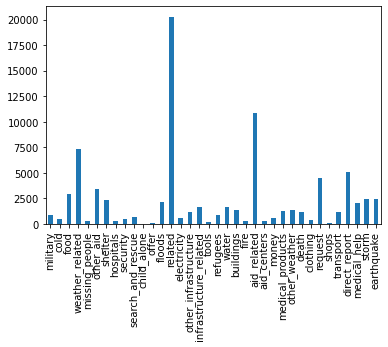

In [32]:
df[category_columns].sum().plot.bar()

## Preprocessing text

In [33]:
message_samples = df['message'].sample(20).to_list()
message_samples

['Listen.. Until now, you did not respond to my request for a tent. It is important for me you know.. ',
 'One hundred percent of your gift goes to relief and recovery efforts.',
 'He said that 124 homeguards were deployed to safeguard the 124 km long embankment in Bhojpur district.',
 'I need a job to take care of myself and my familly. ',
 'The drawings show kitchen counters built low down on the wall, cupboards at floor level and sinks raised about a metre from the ground.',
 'WE NEED FOOD CAN YOU HELP US? ',
 "The President told the delegation that the Concept of Operations for an African-led force to assist Mali recover its territory from the separatist groups had been submitted to the UN Security Council in response to the Council's 45-day deadline for the clarification of aspects of the proposed deployment.",
 'In Semarang, a landslide displaced 32 families from the Tangkil Baru residential complex in Sukorejo subdistrict, Gunungpati district, whose houses were destroyed.',
 '**

### Tokenize function

In [34]:
english_stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
def tokenize(message):
    message = message.lower()
    message = re.sub(r'[^A-Za-z]', ' ', message)
    tokens = word_tokenize(message)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in english_stopwords]
    return tokens

print(list(map(tokenize, message_samples)))

[['listen', 'respond', 'request', 'tent', 'important', 'know'], ['one', 'hundred', 'percent', 'gift', 'go', 'relief', 'recovery', 'effort'], ['said', 'homeguards', 'deployed', 'safeguard', 'km', 'long', 'embankment', 'bhojpur', 'district'], ['need', 'job', 'take', 'care', 'familly'], ['drawing', 'show', 'kitchen', 'counter', 'built', 'low', 'wall', 'cupboard', 'floor', 'level', 'sink', 'raised', 'metre', 'ground'], ['need', 'food', 'help', 'u'], ['president', 'told', 'delegation', 'concept', 'operation', 'african', 'led', 'force', 'assist', 'mali', 'recover', 'territory', 'separatist', 'group', 'submitted', 'un', 'security', 'council', 'response', 'council', 'day', 'deadline', 'clarification', 'aspect', 'proposed', 'deployment'], ['semarang', 'landslide', 'displaced', 'family', 'tangkil', 'baru', 'residential', 'complex', 'sukorejo', 'subdistrict', 'gunungpati', 'district', 'whose', 'house', 'destroyed'], ['lesson', 'learned', 'participant', 'also', 'drew', 'heavily', 'lesson', 'learne

### Bag of Words

In [35]:
count_vectorizer = CountVectorizer(tokenizer=tokenize)
sample_bow_transform = count_vectorizer.fit_transform(df['message'].sample(8))
sample_bow_transform = pd.DataFrame.sparse.from_spmatrix(sample_bow_transform, columns=count_vectorizer.get_feature_names())
sample_bow_transform

,already,amount,anything,b,bannu,best,beyond,boat,canal,card,...,vietnamese,watan,watching,water,wearing,well,without,work,would,writed
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,3,0,0,0,0,0,0
1,0,1,0,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,1,2,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0


In [73]:
count_vectorizer_2 = CountVectorizer(tokenizer=tokenize, ngram_range=(1, 3), max_features=50)
sample_bow_transform_2 = count_vectorizer_2.fit_transform(df['message'].sample(8))
sample_bow_transform_2 = pd.DataFrame.sparse.from_spmatrix(sample_bow_transform_2, columns=count_vectorizer_2.get_feature_names())
sample_bow_transform_2

,affected,help,lower health,lower health risk,manning,manning national,manning national hotline,may,may know,may know school,...,reduces,reduces cooking,reduces cooking time,reducing,reducing unhealthy,reducing unhealthy smoke,relax,relax head,relax head family,stop
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
3,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
5,0,0,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Tfidf Vectorizer

In [36]:
tfidf_transformer = TfidfTransformer()
sample_tfidf_transform = tfidf_transformer.fit_transform(sample_bow_transform)
sample_tfidf_transform = pd.DataFrame.sparse.from_spmatrix(sample_tfidf_transform, columns=count_vectorizer.get_feature_names())
sample_tfidf_transform

,already,amount,anything,b,bannu,best,beyond,boat,canal,card,...,vietnamese,watan,watching,water,wearing,well,without,work,would,writed
0,0.000000,0.00000,0.000000,0.209877,0.000000,0.000000,0.00000,0.00000,0.209877,0.000000,...,0.00000,0.000000,0.000000,0.62963,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000
1,0.000000,0.15039,0.000000,0.000000,0.000000,0.000000,0.15039,0.15039,0.000000,0.000000,...,0.15039,0.000000,0.000000,0.00000,0.000000,0.15039,0.000000,0.15039,0.30078,0.000000
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.280581,0.00000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.280581,0.00000,0.280581,0.00000,0.000000,0.00000,0.00000,0.000000
3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000
4,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000
5,0.353553,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.353553
6,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000
7,0.000000,0.00000,0.225289,0.000000,0.225289,0.000000,0.00000,0.00000,0.000000,0.225289,...,0.00000,0.225289,0.000000,0.00000,0.000000,0.00000,0.225289,0.00000,0.00000,0.000000


<AxesSubplot:>

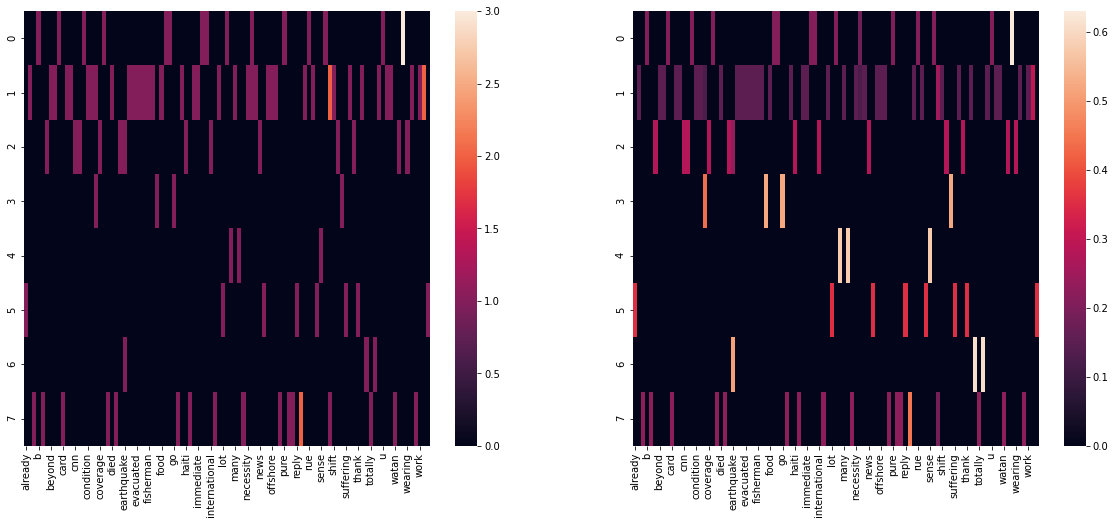

In [37]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.heatmap(sample_bow_transform)
plt.subplot(1, 2, 2)
sns.heatmap(sample_tfidf_transform)

### Split into X and Y

In [38]:
X = df['message']
Y = df[category_columns]

In [39]:
Y.max()

military                  1
cold                      1
food                      1
weather_related           1
missing_people            1
other_aid                 1
shelter                   1
hospitals                 1
security                  1
search_and_rescue         1
child_alone               0
offer                     1
floods                    1
related                   2
electricity               1
other_infrastructure      1
infrastructure_related    1
tools                     1
refugees                  1
water                     1
buildings                 1
fire                      1
aid_related               1
aid_centers               1
money                     1
medical_products          1
other_weather             1
death                     1
clothing                  1
request                   1
shops                     1
transport                 1
direct_report             1
medical_help              1
storm                     1
earthquake          

Must make this binary. I will drop child_alone because there is no data for it. Then I will make the max for related 1. Then turn the whole thing into boolean

In [40]:
Y = Y.drop(columns=['child_alone'])

In [41]:
Y.related = Y.related.replace(2, 1)

In [42]:
for column in Y.columns:
    Y[column] = Y[column].astype(bool)

In [43]:
Y.head()

,military,cold,food,weather_related,missing_people,other_aid,shelter,hospitals,security,search_and_rescue,...,other_weather,death,clothing,request,shops,transport,direct_report,medical_help,storm,earthquake
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [44]:
random_cols = ['offer', 'medical_help', 'security']
Y[random_cols].sum() == df[random_cols].sum()

offer           True
medical_help    True
security        True
dtype: bool

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [46]:
list(map(lambda df: df.shape, [X, Y, X_train, X_test, Y_train, Y_test]))

[(26216,), (26216, 35), (19662,), (6554,), (19662, 35), (6554, 35)]

### Building pipeline with model

In [47]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('cfr', MultiOutputClassifier(LogisticRegression()))
])

In [48]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('cfr', MultiOutputClassifier(estimator=LogisticRegression()))])

In [49]:
Y_pred = pipeline.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, columns=Y_test.columns, index=X_test.index)
Y_pred.shape

(6554, 35)

<AxesSubplot:title={'center':'predicted'}>

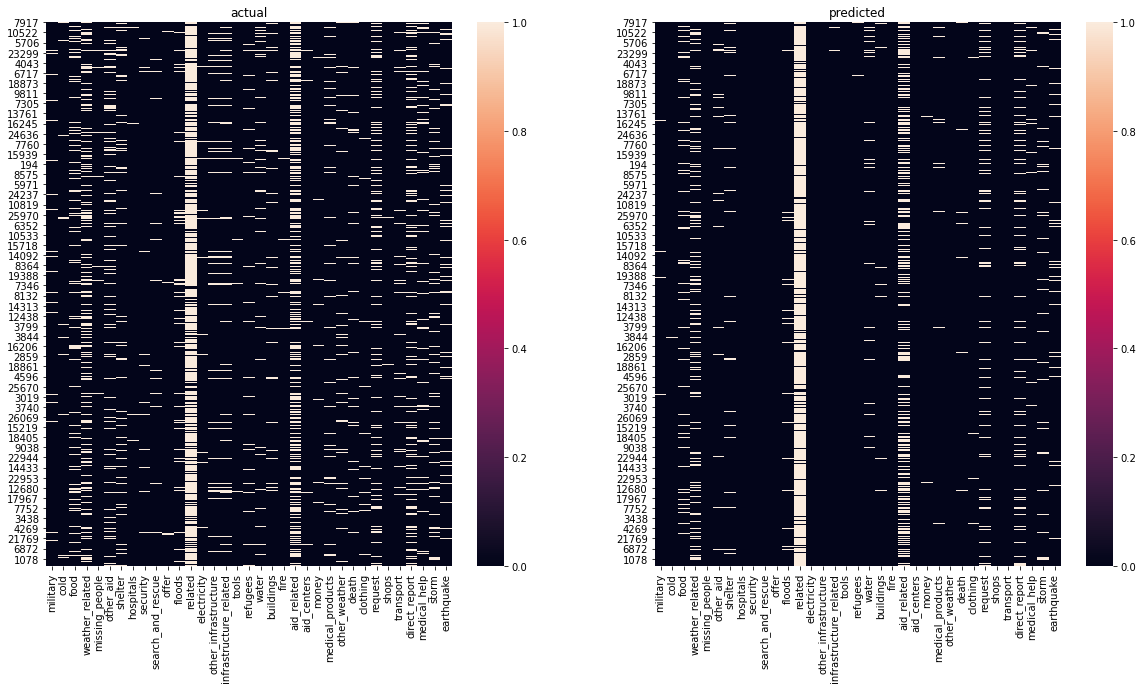

In [50]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('actual')
#Y_test.sum().plot.bar()
sns.heatmap(Y_test)
plt.subplot(1, 2, 2)
plt.title('predicted')
#Y_pred.sum().plot.bar()
sns.heatmap(Y_pred)

In [51]:
(Y_test == Y_pred).mean()

military                  0.970095
cold                      0.979860
food                      0.942020
weather_related           0.869545
missing_people            0.988862
other_aid                 0.872139
shelter                   0.940647
hospitals                 0.991303
security                  0.982301
search_and_rescue         0.976655
offer                     0.994965
floods                    0.949802
related                   0.817974
electricity               0.978639
other_infrastructure      0.956363
infrastructure_related    0.937443
tools                     0.993439
refugees                  0.967806
water                     0.958193
buildings                 0.957583
fire                      0.989930
aid_related               0.780897
aid_centers               0.987641
money                     0.980470
medical_products          0.953158
other_weather             0.949496
death                     0.963991
clothing                  0.986115
request             

### Metrics

In [52]:
(Y_pred.sum() == 0).count()

35

In [53]:
accuracy_score(Y_test, Y_pred)

0.282575526396094

In [54]:
f1_score(Y_test, Y_pred, average='micro')

0.6453850676072899

In [55]:
precision_score(Y_test, Y_pred, average='micro')

0.8152989231340513

In [56]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.60      0.06      0.11       200
           1       0.80      0.09      0.15       141
           2       0.88      0.56      0.69       745
           3       0.85      0.63      0.72      1773
           4       0.00      0.00      0.00        73
           5       0.59      0.10      0.17       864
           6       0.83      0.41      0.55       581
           7       0.00      0.00      0.00        56
           8       0.00      0.00      0.00       116
           9       1.00      0.04      0.07       159
          10       0.00      0.00      0.00        33
          11       0.92      0.40      0.56       519
          12       0.83      0.96      0.89      4991
          13       0.77      0.07      0.13       147
          14       0.20      0.00      0.01       283
          15       0.53      0.02      0.04       411
          16       0.00      0.00      0.00        43
          17       0.62    

c:\users\sivakar\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sivakar\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sivakar\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

In [57]:
def build_pipeline_and_report_score(classifier):
    pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('cfr', classifier)
    ])
    pipeline.fit(X_train, Y_train)
    score = pipeline.score(X_test, Y_test)
    return score

In [58]:
build_pipeline_and_report_score(MultiOutputClassifier(BernoulliNB()))

0.2070491303021056

In [59]:
#build_pipeline_and_report_score(RandomForestClassifier( \))

In [60]:
build_pipeline_and_report_score(MultiOutputClassifier(LinearSVC()))

0.28669514800122065

In [61]:
build_pipeline_and_report_score(DecisionTreeClassifier())

0.2422947818126335